In [4]:
# Colab: Custom conditional GAN for your selected features + label
# Runs on GPU if available. Prints D/G losses each epoch and checkpoints.

!pip install -q pandas scikit-learn matplotlib

import os, time, math, pathlib
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [2]:
import shutil
from google.colab import drive
drive.mount("/content/gdrive")
# Change the code below if the path to the dataset is different for you.
shutil.unpack_archive("/content/gdrive/MyDrive/ddos_dataset.zip", "/tmp/")

Mounted at /content/gdrive


In [5]:
# 1) CSV yükle (yolunu değiştir)
csv_path = r"/tmp/dataset_sdn.csv"   # kendi dosya yolunu yaz
df = pd.read_csv(csv_path, low_memory=False)
print(df.shape)
display(df.head())

(104345, 23)


,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,...,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
0,11425,1,10.0.0.1,10.0.0.8,45304,48294064,100,716000000,1.010000e+11,3,...,451,0,UDP,3,143928631,3917,0,0.0,0.0,0
1,11605,1,10.0.0.1,10.0.0.8,126395,134737070,280,734000000,2.810000e+11,2,...,451,0,UDP,4,3842,3520,0,0.0,0.0,0
2,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,1,3795,1242,0,0.0,0.0,0
3,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,2,3688,1492,0,0.0,0.0,0
4,11425,1,10.0.0.2,10.0.0.8,90333,96294978,200,744000000,2.010000e+11,3,...,451,0,UDP,3,3413,3665,0,0.0,0.0,0


In [6]:
# CONFIG
SELECTED_FEATURES = [
    'dt','pktcount','bytecount','dur','tot_dur',
    'packetins','pktperflow','byteperflow','pktrate','tx_bytes'
]
TARGET_COL = None   # None => auto detect from csv (last col or 'label')
MODEL_DIR = "/content/drive/MyDrive/ctgan_custom_checkpoints"  # directory to save checkpoints
BATCH_SIZE = 256
Z_DIM = 64               # noise vector size
HIDDEN_DIM = 128         # hidden layer width
LR = 2e-4
BETAS = (0.5, 0.999)
EPOCHS = 100
PRINT_EVERY = 1          # print losses every epoch
CHECKPOINT_EVERY = 10    # save model every N epochs
D_UPDATES = 1            # discriminator updates per gen update
SEED = 42

In [7]:
np.random.seed(SEED)
import torch
torch.manual_seed(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == 'cpu':
    print("Noted: CUDA not available — training will run on CPU (slower). If you want GPU, enable Runtime->Change runtime type->GPU")

Device: cuda


In [8]:
# Load data
csv_path = r"/tmp/dataset_sdn.csv"
df = pd.read_csv(csv_path, low_memory=False)
print("Original shape:", df.shape)
# detect target column if not set
if TARGET_COL is None:
    for cand in ['label','Label','class','Class','attack','Attack','target','Target','flow_label']:
        if cand in df.columns:
            TARGET_COL = cand
            break
    if TARGET_COL is None:
        TARGET_COL = df.columns[-1]
print("Using target column:", TARGET_COL)

Original shape: (104345, 23)
Using target column: label


In [9]:
# Build working dataframe: selected features + target
use_cols = [c for c in SELECTED_FEATURES if c in df.columns] + [TARGET_COL]
df_sel = df[use_cols].copy()
print("Using columns:", df_sel.columns.tolist())

# Drop missing rows (or you can impute instead)
before = len(df_sel)
df_sel = df_sel.dropna(axis=0, how='any').reset_index(drop=True)
print(f"Dropped {before-len(df_sel)} rows due to NaNs. Remaining rows: {len(df_sel)}")

# Ensure label is integer 0/1
if df_sel[TARGET_COL].dtype != int and df_sel[TARGET_COL].dtype != 'int64':
    try:
        df_sel[TARGET_COL] = df_sel[TARGET_COL].astype(int)
    except:
        df_sel[TARGET_COL] = pd.factorize(df_sel[TARGET_COL])[0]
print("Label value counts:\n", df_sel[TARGET_COL].value_counts())

Using columns: ['dt', 'pktcount', 'bytecount', 'dur', 'tot_dur', 'packetins', 'pktperflow', 'byteperflow', 'pktrate', 'tx_bytes', 'label']
Dropped 0 rows due to NaNs. Remaining rows: 104345
Label value counts:
 label
0    63561
1    40784
Name: count, dtype: int64


In [10]:
# Separate X and y
X = df_sel[SELECTED_FEATURES].astype(float).values
y = df_sel[TARGET_COL].astype(int).values.reshape(-1,1)  # column vector

# Scale features to [0,1] for generator output (MinMax helps with BCE)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Build combined array: features + label (label as integer 0/1)
data_combined = np.hstack([X_scaled, y])  # last column is label

# Train/test split (we'll train GAN on full training portion)
X_train, X_val = train_test_split(data_combined, test_size=0.1, random_state=SEED, stratify=y)

print("Train rows:", len(X_train), "Val rows:", len(X_val))

# Torch dataset / dataloader
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, arr):
        self.arr = arr.astype(np.float32)
    def __len__(self):
        return len(self.arr)
    def __getitem__(self, idx):
        return self.arr[idx]

train_loader = torch.utils.data.DataLoader(TabularDataset(X_train), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

FEATURE_DIM = X_scaled.shape[1]
LABEL_DIM = 1   # binary label (we will concatenate as scalar or one-hot)
COND_DIM = 1    # using scalar 0/1; could convert to one-hot if multi-class

print("FEATURE_DIM:", FEATURE_DIM, "LABEL_DIM:", LABEL_DIM)

# Utilities: convert label scalar to one-hot if desired (not necessary for binary)
def label_to_onehot(label_batch, num_classes=2):
    # label_batch: tensor shape (B,1) with 0/1
    b = label_batch.long().squeeze(-1)
    oh = torch.nn.functional.one_hot(b, num_classes=num_classes).float()
    return oh


Train rows: 93910 Val rows: 10435
FEATURE_DIM: 10 LABEL_DIM: 1


In [12]:
# Simple MLP Generator and Discriminator (conditional)
import torch.nn as nn
class Generator(nn.Module):
    def __init__(self, z_dim, cond_dim, out_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim + cond_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, out_dim),
            nn.Sigmoid()  # because features scaled to [0,1]
        )
    def forward(self, z, cond):
        # z: (B, z_dim), cond: (B, cond_dim)
        x = torch.cat([z, cond], dim=1)
        return self.net(x)

class Discriminator(nn.Module):
    def __init__(self, in_dim, cond_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim + cond_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    def forward(self, x, cond):
        x = torch.cat([x, cond], dim=1)
        return self.net(x)

G = Generator(Z_DIM, COND_DIM, FEATURE_DIM, hidden_dim=HIDDEN_DIM).to(device)
D = Discriminator(FEATURE_DIM, COND_DIM, hidden_dim=HIDDEN_DIM).to(device)

optG = torch.optim.Adam(G.parameters(), lr=LR, betas=BETAS)
optD = torch.optim.Adam(D.parameters(), lr=LR, betas=BETAS)
criterion = nn.BCELoss()

# Make model dir
pathlib.Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)
print("Checkpoint dir:", MODEL_DIR)


Checkpoint dir: /content/drive/MyDrive/ctgan_custom_checkpoints


Epoch [1/100]  D_loss: 0.6382  G_loss: 0.8737  elapsed: 1.9s
Epoch [2/100]  D_loss: 0.6385  G_loss: 0.8745  elapsed: 3.8s
Epoch [3/100]  D_loss: 0.6385  G_loss: 0.8760  elapsed: 5.7s
Epoch [4/100]  D_loss: 0.6369  G_loss: 0.8758  elapsed: 7.6s
Epoch [5/100]  D_loss: 0.6383  G_loss: 0.8761  elapsed: 9.7s
Epoch [6/100]  D_loss: 0.6375  G_loss: 0.8771  elapsed: 12.1s
Epoch [7/100]  D_loss: 0.6370  G_loss: 0.8771  elapsed: 14.0s
Epoch [8/100]  D_loss: 0.6374  G_loss: 0.8766  elapsed: 15.9s
Epoch [9/100]  D_loss: 0.6367  G_loss: 0.8777  elapsed: 17.8s
Epoch [10/100]  D_loss: 0.6369  G_loss: 0.8790  elapsed: 19.8s
Saved checkpoint: /content/drive/MyDrive/ctgan_custom_checkpoints/cgan_epoch10.pt
Epoch [11/100]  D_loss: 0.6367  G_loss: 0.8794  elapsed: 22.2s
Epoch [12/100]  D_loss: 0.6366  G_loss: 0.8790  elapsed: 25.1s
Epoch [13/100]  D_loss: 0.6369  G_loss: 0.8797  elapsed: 27.1s
Epoch [14/100]  D_loss: 0.6361  G_loss: 0.8794  elapsed: 28.9s
Epoch [15/100]  D_loss: 0.6362  G_loss: 0.8791  el

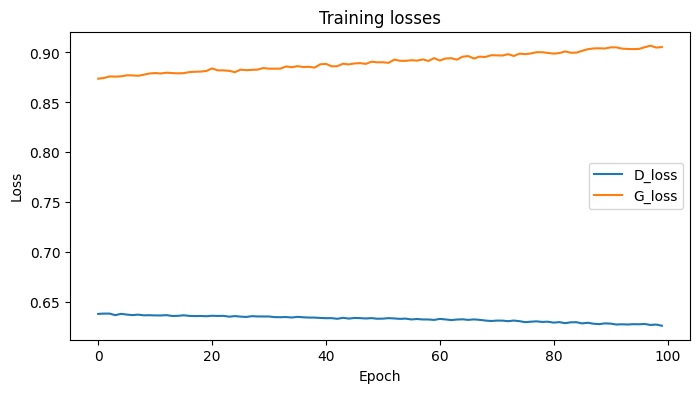

In [14]:
# Training loop
fixed_noise = torch.randn(16, Z_DIM, device=device)
# for conditional fixed labels we can visualize both classes
fixed_labels = torch.tensor([[0.],[1.]]*8, device=device).float()[:16]  # alternating 0/1

history = {'D_loss':[], 'G_loss':[]}
start_time = time.time()
for epoch in range(1, EPOCHS+1):
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    batches = 0
    for batch in train_loader:
        batch = batch.to(device)           # shape (B, FEATURE_DIM+1)
        real_x = batch[:, :FEATURE_DIM]    # features in [0,1]
        real_label = batch[:, FEATURE_DIM:].to(device)  # shape (B,1)

        # prepare condition vector (use scalar 0/1); reshape to (B,1)
        cond_real = real_label.float()

        B = real_x.size(0)
        # 1) Train Discriminator D on real and fake
        for _ in range(D_UPDATES):
            # real labels -> slightly smooth to 0.9
            real_targets = torch.full((B,1), 0.9, dtype=torch.float, device=device)
            fake_targets = torch.zeros((B,1), dtype=torch.float, device=device)

            D.zero_grad()
            out_real = D(real_x, cond_real)
            lossD_real = criterion(out_real, real_targets)

            # generate fake conditioned on same cond distribution
            z = torch.randn(B, Z_DIM, device=device)
            # sample cond for fake: use real cond (conditional sampling preserving label distribution)
            cond_for_fake = cond_real
            fake_x = G(z, cond_for_fake).detach()  # detach for D update
            out_fake = D(fake_x, cond_for_fake)
            lossD_fake = criterion(out_fake, fake_targets)

            lossD = (lossD_real + lossD_fake) * 0.5
            lossD.backward()
            optD.step()

        # 2) Train Generator G to fool D
        G.zero_grad()
        z2 = torch.randn(B, Z_DIM, device=device)
        # sample cond for generator: use real cond (alternatively sample label distribution)
        cond_for_gen = cond_real
        gen_x = G(z2, cond_for_gen)
        pred = D(gen_x, cond_for_gen)
        # Generator wants D to predict real (1.0) => use smoothed real label 0.9
        g_targets = torch.full((B,1), 0.9, dtype=torch.float, device=device)
        lossG = criterion(pred, g_targets)
        lossG.backward()
        optG.step()

        epoch_d_loss += lossD.item()
        epoch_g_loss += lossG.item()
        batches += 1

    # epoch summary
    avg_d = epoch_d_loss / batches
    avg_g = epoch_g_loss / batches
    history['D_loss'].append(avg_d)
    history['G_loss'].append(avg_g)

    if epoch % PRINT_EVERY == 0:
        elapsed = time.time() - start_time
        print(f"Epoch [{epoch}/{EPOCHS}]  D_loss: {avg_d:.4f}  G_loss: {avg_g:.4f}  elapsed: {elapsed:.1f}s")

    # checkpoint
    if epoch % CHECKPOINT_EVERY == 0 or epoch == EPOCHS:
        ckpt = {
            'epoch': epoch,
            'G_state': G.state_dict(),
            'D_state': D.state_dict(),
            'optG_state': optG.state_dict(),
            'optD_state': optD.state_dict(),
            'scaler': scaler
        }
        ckpt_path = os.path.join(MODEL_DIR, f"cgan_epoch{epoch}.pt")
        torch.save(ckpt, ckpt_path)
        print("Saved checkpoint:", ckpt_path)

# Plot losses
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(history['D_loss'], label='D_loss')
plt.plot(history['G_loss'], label='G_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training losses')
plt.show()

In [15]:
# === After training: sample synthetic data conditioned on labels 0 and 1 ===
def sample_synthetic(n_samples=1000, label=0):
    G.eval()
    with torch.no_grad():
        z = torch.randn(n_samples, Z_DIM, device=device)
        cond = torch.full((n_samples, 1), float(label), device=device)
        syn = G(z, cond).cpu().numpy()
    # inverse transform to original scale
    syn_inv = scaler.inverse_transform(syn)
    return syn_inv

# Generate synthetic samples for each label
syn0 = sample_synthetic(500, label=0)
syn1 = sample_synthetic(500, label=1)
print("Generated samples shapes (class0, class1):", syn0.shape, syn1.shape)

# Build dataframe and combine them
syn_df0 = pd.DataFrame(syn0, columns=SELECTED_FEATURES)
syn_df0[TARGET_COL] = 0
syn_df1 = pd.DataFrame(syn1, columns=SELECTED_FEATURES)
syn_df1[TARGET_COL] = 1

# Merge both into one synthetic dataset
synthetic_full = pd.concat([syn_df0, syn_df1], ignore_index=True)

# Save synthetic dataset to CSV
SAMPLE_SAVE = os.path.join(MODEL_DIR, "synthetic_mixed.csv")
synthetic_full.to_csv(SAMPLE_SAVE, index=False)
print("Saved synthetic CSV to:", SAMPLE_SAVE)

# === Add unified variable for analysis ===
synthetic_data = synthetic_full.copy()
print("synthetic_data variable created. Shape:", synthetic_data.shape)



Generated samples shapes (class0, class1): (500, 10) (500, 10)
Saved synthetic CSV to: /content/drive/MyDrive/ctgan_custom_checkpoints/synthetic_mixed.csv
synthetic_data variable created. Shape: (1000, 11)


In [16]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, entropy, wasserstein_distance
from sklearn.preprocessing import MinMaxScaler

# Real ve sentetik verileri normalize et
scaler = MinMaxScaler()
real_scaled = pd.DataFrame(scaler.fit_transform(df_sel), columns=df_sel.columns)
synthetic_scaled = pd.DataFrame(scaler.transform(synthetic_data), columns=df_sel.columns)

metrics = []

for col in df_sel.columns:
    real_col = real_scaled[col]
    synth_col = synthetic_scaled[col]

    ks_stat, ks_p = ks_2samp(real_col, synth_col)
    kl_div = entropy(np.histogram(real_col, bins=50, density=True)[0] + 1e-6,
                     np.histogram(synth_col, bins=50, density=True)[0] + 1e-6)
    w_dist = wasserstein_distance(real_col, synth_col)

    metrics.append({
        'Feature': col,
        'KS_stat': round(ks_stat, 4),
        'KS_pvalue': round(ks_p, 4),
        'KL_divergence': round(kl_div, 4),
        'Wasserstein_distance': round(w_dist, 4)
    })

results_df = pd.DataFrame(metrics)
print(results_df.sort_values(by='KS_stat', ascending=True))


        Feature  KS_stat  KS_pvalue  KL_divergence  Wasserstein_distance
0            dt   0.0586     0.0021         0.3044                0.0201
4       tot_dur   0.0654     0.0004         0.1991                0.0189
3           dur   0.0746     0.0000         0.2055                0.0194
5     packetins   0.0978     0.0000         0.4211                0.0367
10        label   0.1091     0.0000         0.0240                0.1091
1      pktcount   0.1788     0.0000         0.2457                0.0167
6    pktperflow   0.2010     0.0000         3.1918                0.0092
2     bytecount   0.2078     0.0000         0.0581                0.0114
7   byteperflow   0.2345     0.0000         2.2535                0.0094
8       pktrate   0.2490     0.0000         2.2545                0.0093
9      tx_bytes   0.3037     0.0000         0.1998                0.0184


=== TSTR Evaluation ===
Accuracy on real data: 0.8756
F1-score on real data: 0.8524

Classification Report:
              precision    recall  f1-score   support

           0     0.9424    0.8476    0.8925     63561
           1     0.7947    0.9192    0.8524     40784

    accuracy                         0.8756    104345
   macro avg     0.8685    0.8834    0.8724    104345
weighted avg     0.8846    0.8756    0.8768    104345



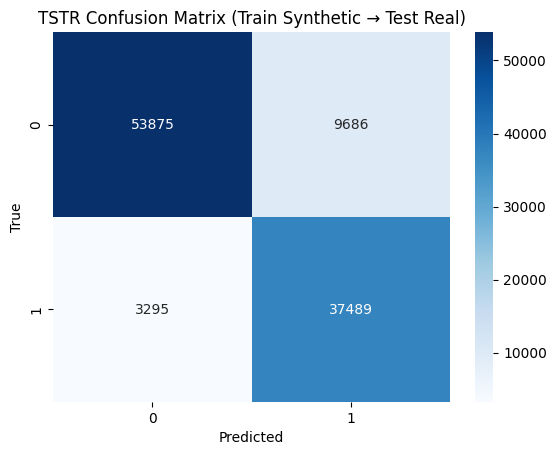

In [17]:
# Train on Synthetic, Test on Real” (TSTR)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Real ve synthetic veriyi ayır
real_df = df.copy()  # orijinal dataframe'in
real_X = real_df[SELECTED_FEATURES]
real_y = real_df[TARGET_COL]

synthetic_X = synthetic_data[SELECTED_FEATURES]
synthetic_y = synthetic_data[TARGET_COL]

# Sentetik veriyi train, gerçek veriyi test olarak kullan
X_train, y_train = synthetic_X, synthetic_y
X_test, y_test = real_X, real_y

# Modeli eğit
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Gerçek veride test et
y_pred = clf.predict(X_test)

# Sonuçları hesapla
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("=== TSTR Evaluation ===")
print(f"Accuracy on real data: {acc:.4f}")
print(f"F1-score on real data: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Opsiyonel: Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("TSTR Confusion Matrix (Train Synthetic → Test Real)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
